In [2]:
import torch
import einops
import math

from einops.layers.torch import Rearrange
from dataclasses import dataclass

from utils.config import NetworkConfig, WorldConfig
from utils.components import *

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [61]:
None > 2

TypeError: '>' not supported between instances of 'NoneType' and 'int'

In [59]:
npe = ContinuousPositionalEmbedding(64, 3 * [(1e-4, 2.)])

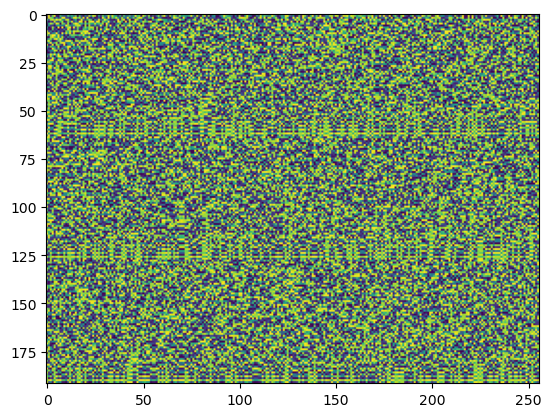

In [60]:
plt.imshow(npe(torch.rand((256, 3))).T)